In [101]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Library berhasil di-import!")
print(f"TensorFlow Version: {tf.__version__}")

Library berhasil di-import!
TensorFlow Version: 2.19.0


In [102]:
import pandas as pd

# Membaca file CSV dengan header normal (karena dataset Anda sudah punya header)
df = pd.read_csv('data.csv')  # Ganti 'data.csv' dengan nama file Anda

print("Dataset berhasil dibaca.")
print(f"Shape: {df.shape}")
print("\n5 baris pertama:")
df.head()

Dataset berhasil dibaca.
Shape: (174, 452)

5 baris pertama:


,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [103]:
# Periksa tipe data terlebih dahulu
print("--- INFORMASI AWAL DATASET ---")
df.info()

# Daftar kolom yang harus numeric (kecuali ID dan class)
numeric_cols = []
for col in df.columns:
    if col not in ['ID', 'class']:
        numeric_cols.append(col)

# Konversi ke numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n--- INFORMASI SETELAH KONVERSI ---")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")
df.info()

--- INFORMASI AWAL DATASET ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB

--- INFORMASI SETELAH KONVERSI ---
Jumlah Baris: 174
Jumlah Kolom: 452
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


In [104]:
# Menghapus baris yang memiliki missing values
df_clean = df.dropna()

print("--- LAPORAN KONDISI DATA ---")
print(f"Jumlah Data Sebelum Cleaning: {df.shape[0]}")
print(f"Jumlah Data Setelah Cleaning: {df_clean.shape[0]}")
print(f"Data yang dihapus: {df.shape[0] - df_clean.shape[0]} baris")

# Cek distribusi kelas
print("\nSebaran Kelas:")
print(df_clean['class'].value_counts())
print(f"\nProporsi: {(df_clean['class'].value_counts() / len(df_clean) * 100).round(2)}%")

--- LAPORAN KONDISI DATA ---
Jumlah Data Sebelum Cleaning: 174
Jumlah Data Setelah Cleaning: 174
Data yang dihapus: 0 baris

Sebaran Kelas:
class
P    89
H    85
Name: count, dtype: int64

Proporsi: class
P    51.15
H    48.85
Name: count, dtype: float64%


/tmp/ipython-input-2845526230.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='class', palette='viridis')


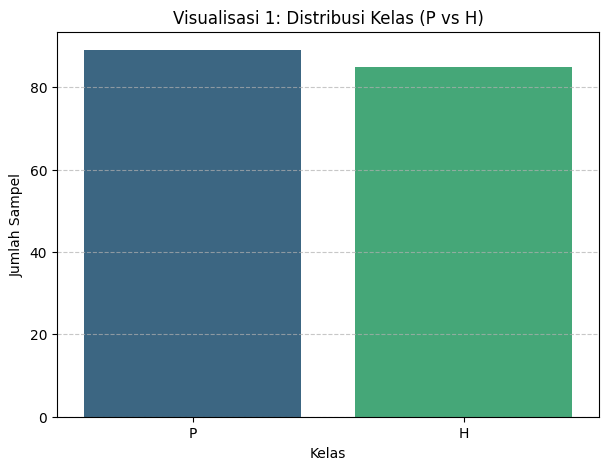

Kelas yang ada: ['P' 'H']


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.countplot(data=df_clean, x='class', palette='viridis')

plt.title('Visualisasi 1: Distribusi Kelas (P vs H)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Jika ingin tahu apa saja kelas yang ada
print("Kelas yang ada:", df_clean['class'].unique())

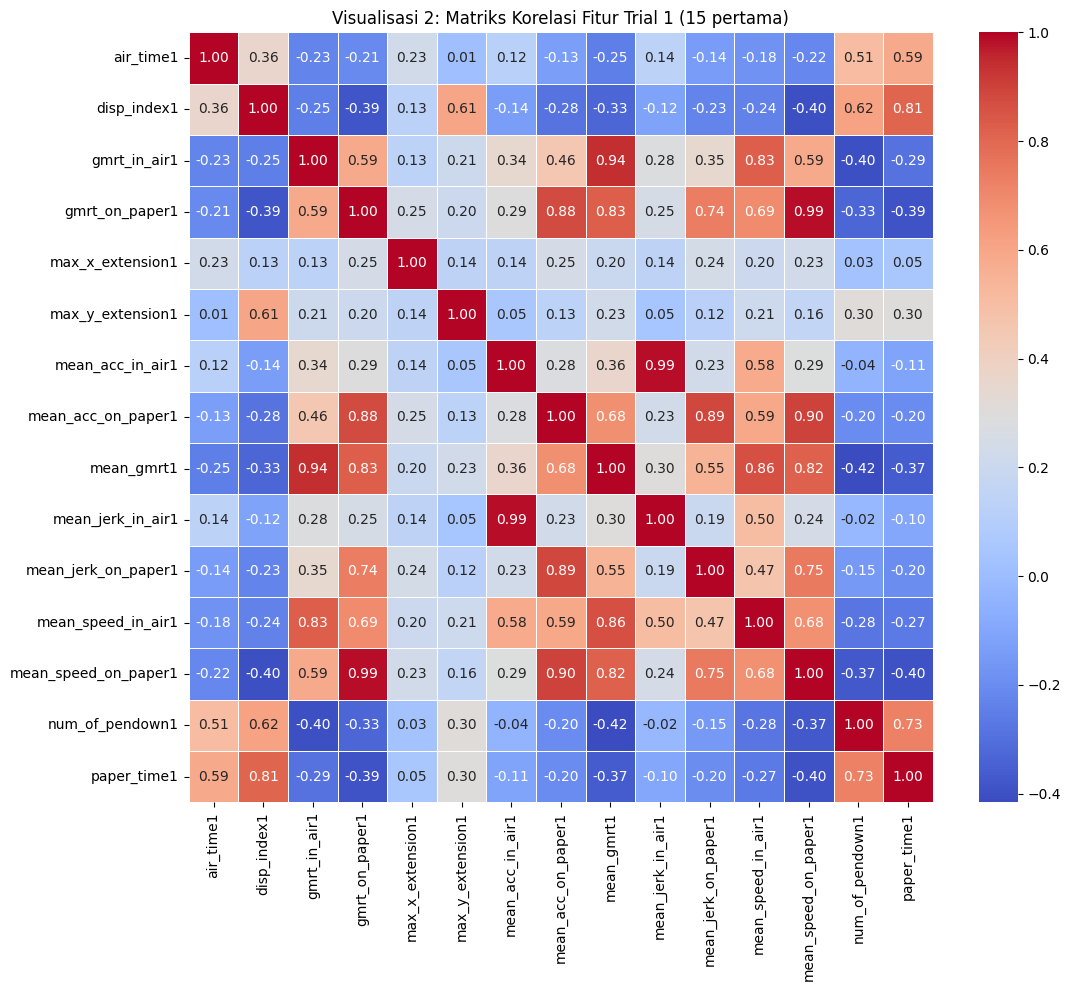

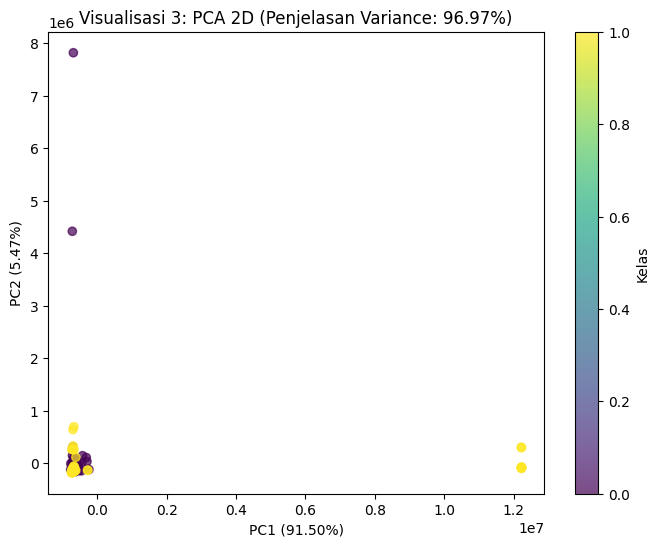

In [106]:
# Karena dataset Anda sangat besar (banyak kolom), pilih subset atau gunakan PCA

# Pilihan 1: Analisis korelasi untuk fitur-fitur trial pertama saja
trial1_cols = [col for col in df_clean.columns if '1' in col and col not in ['ID', 'class']]

if len(trial1_cols) > 0:
    plt.figure(figsize=(12, 10))
    corr_matrix = df_clean[trial1_cols[:15]].corr()  # Ambil 15 fitur pertama
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Visualisasi 2: Matriks Korelasi Fitur Trial 1 (15 pertama)')
    plt.show()

# Pilihan 2: Analisis PCA untuk reduksi dimensi
from sklearn.decomposition import PCA
import numpy as np # Import numpy

# Ambil hanya fitur numerik
X_numeric = df_clean.drop(columns=['ID', 'class']).select_dtypes(include=[np.number])

# Lakukan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=pd.factorize(df_clean['class'])[0],
                     cmap='viridis', alpha=0.7)
plt.title('Visualisasi 3: PCA 2D (Penjelasan Variance: {:.2f}%)'.format(
    pca.explained_variance_ratio_.sum() * 100))
plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.colorbar(scatter, label='Kelas')
plt.show()

/tmp/ipython-input-3368166648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='class', y=feature_to_analyze, palette='Set2')


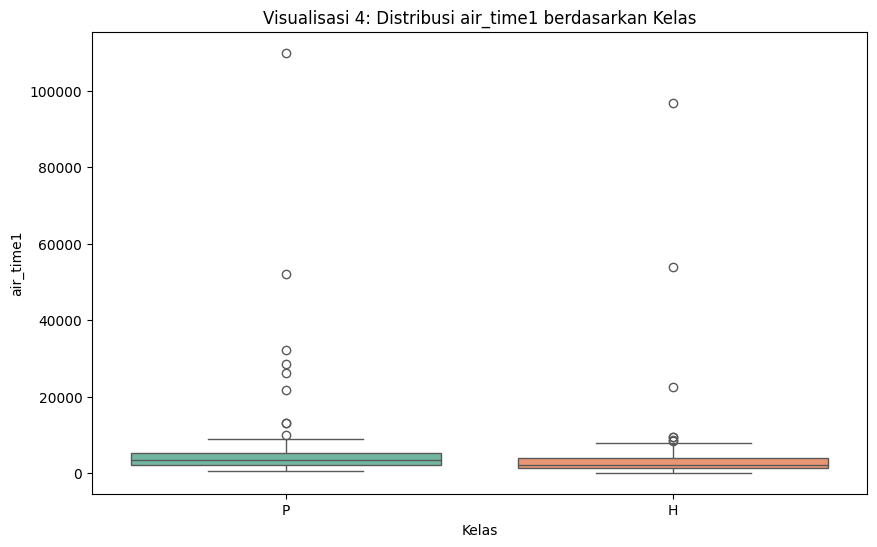


Statistik air_time1 per kelas:
       count         mean           std    min     25%     50%     75%  \
class                                                                    
H       85.0  4781.647059  11893.898351   65.0  1310.0  2130.0  3900.0   
P       89.0  6507.022472  13351.853628  440.0  2105.0  3490.0  5100.0   

            max  
class            
H       96686.0  
P      109965.0  


In [107]:
# Pilih beberapa fitur penting untuk dianalisis
feature_to_analyze = 'air_time1'  # Ganti dengan fitur lain jika perlu

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='class', y=feature_to_analyze, palette='Set2')

plt.title(f'Visualisasi 4: Distribusi {feature_to_analyze} berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel(feature_to_analyze)
plt.show()

# Analisis statistik
print(f"\nStatistik {feature_to_analyze} per kelas:")
print(df_clean.groupby('class')[feature_to_analyze].describe())

In [108]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Mengubah kolom 'class' menjadi angka
df_clean['class_code'] = le.fit_transform(df_clean['class'])

# Menampilkan hasil encoding
print("--- HASIL ENCODING TARGET ---")
for i, label in enumerate(le.classes_):
    print(f"Kelas '{label}' diubah menjadi angka: {i}")

# Cek hasil
print("\nContoh data setelah encoding:")
df_clean[['class', 'class_code']].head()

--- HASIL ENCODING TARGET ---
Kelas 'H' diubah menjadi angka: 0
Kelas 'P' diubah menjadi angka: 1

Contoh data setelah encoding:


,class,class_code
0,P,1
1,P,1
2,P,1
3,P,1
4,P,1


In [109]:
# Hapus kolom ID karena tidak digunakan sebagai fitur
X = df_clean.drop(columns=['ID', 'class', 'class_code'])
y = df_clean['class_code']

# Split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Jumlah Data Latih (Training): {X_train.shape[0]} baris, {X_train.shape[1]} fitur")
print(f"Jumlah Data Uji (Testing)   : {X_test.shape[0]} baris, {X_test.shape[1]} fitur")

# Cek distribusi kelas
print("\nDistribusi kelas di Train:")
print(pd.Series(y_train).value_counts())
print("\nDistribusi kelas di Test:")
print(pd.Series(y_test).value_counts())

Jumlah Data Latih (Training): 139 baris, 450 fitur
Jumlah Data Uji (Testing)   : 35 baris, 450 fitur

Distribusi kelas di Train:
class_code
1    71
0    68
Name: count, dtype: int64

Distribusi kelas di Test:
class_code
1    18
0    17
Name: count, dtype: int64


In [110]:
from sklearn.preprocessing import StandardScaler
import joblib # Import joblib

scaler = StandardScaler()

# Fit pada training data saja
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data berhasil dinormalisasi.")
print(f"Shape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")

# Simpan scaler untuk penggunaan nanti
joblib.dump(scaler, 'scaler_handwriting.pkl')

Data berhasil dinormalisasi.
Shape X_train_scaled: (139, 450)
Shape X_test_scaled: (35, 450)


['scaler_handwriting.pkl']

Training Model 1: K-Nearest Neighbors...
Selesai dalam 0.01 detik
Akurasi KNN: 62.86%

Classification Report (KNN):
              precision    recall  f1-score   support

           H       0.58      0.88      0.70        17
           P       0.78      0.39      0.52        18

    accuracy                           0.63        35
   macro avg       0.68      0.64      0.61        35
weighted avg       0.68      0.63      0.61        35



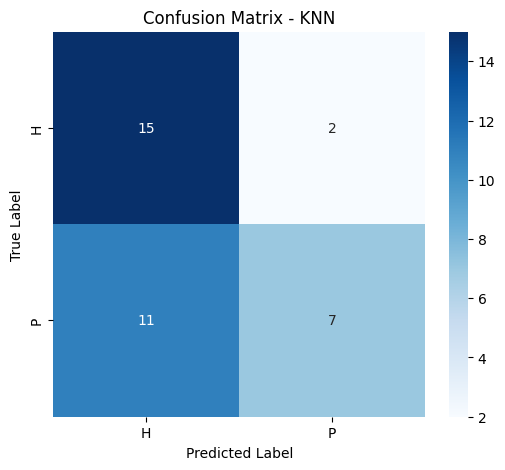

['model_knn.pkl']

In [111]:
import time

print("Training Model 1: K-Nearest Neighbors...")
start_time = time.time()

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)

y_pred_knn = model_knn.predict(X_test_scaled)
knn_time = time.time() - start_time
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Selesai dalam {knn_time:.2f} detik")
print(f"Akurasi KNN: {acc_knn*100:.2f}%")
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - KNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Simpan model
joblib.dump(model_knn, 'model_knn.pkl')

Training Model 2: Random Forest...
Selesai dalam 0.30 detik
Akurasi Random Forest: 71.43%

Classification Report (Random Forest):
              precision    recall  f1-score   support

           H       0.77      0.59      0.67        17
           P       0.68      0.83      0.75        18

    accuracy                           0.71        35
   macro avg       0.73      0.71      0.71        35
weighted avg       0.72      0.71      0.71        35


Top 10 Fitur Paling Penting:
                 feature  importance
413         total_time23    0.045704
305         total_time17    0.032096
269         total_time15    0.026794
233         total_time13    0.023849
143          total_time8    0.021177
396           air_time23    0.020333
252           air_time15    0.020315
397         disp_index23    0.020091
287         total_time16    0.019663
299  mean_speed_in_air17    0.019652


/tmp/ipython-input-1192861273.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


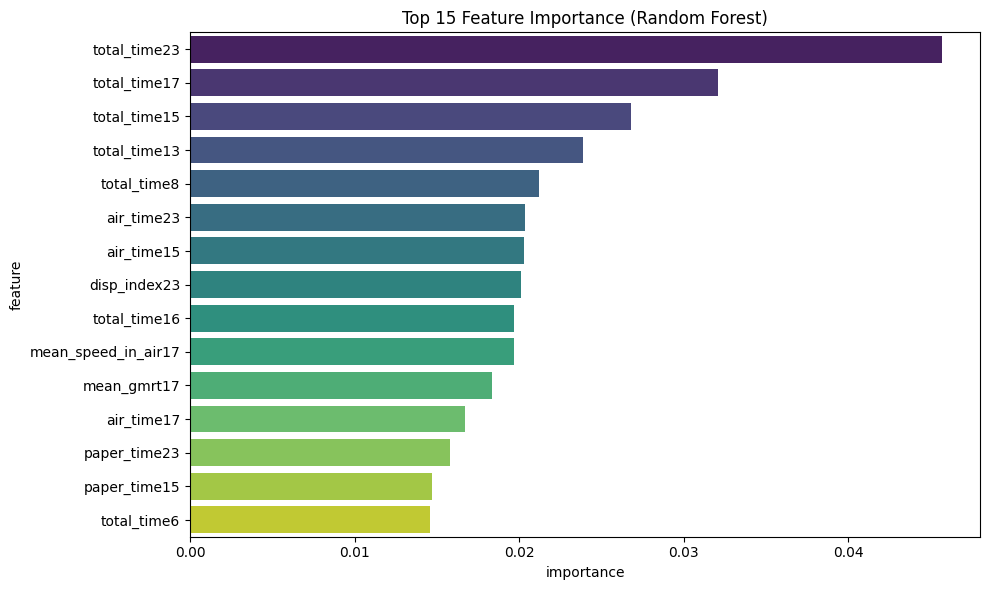

['model_rf.pkl']

In [112]:
print("Training Model 2: Random Forest...")
start_time = time.time()

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)  # RF bisa tanpa scaling

y_pred_rf = model_rf.predict(X_test)
rf_time = time.time() - start_time
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Selesai dalam {rf_time:.2f} detik")
print(f"Akurasi Random Forest: {acc_rf*100:.2f}%")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Fitur Paling Penting:")
print(feature_importance.head(10))

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

joblib.dump(model_rf, 'model_rf.pkl')

Training Model 3: Deep Learning (MLP)...
Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 256)            │       115,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,738 (612.26 KB)

 Trainable params: 156,738 (612.26 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Selesai dalam 3.33 detik
Akurasi Deep Learning: 68.57%

Classification Report (Deep Learning):
              precision    recall  f1-score   support

           H       0.69      0.65      0.67        17
           P       0.68      0.72      0.70        18

    accuracy                           0.69        35
   macro avg       0.69      0.68      0.68        35
weighted avg       0.69      0.69      0.69        35



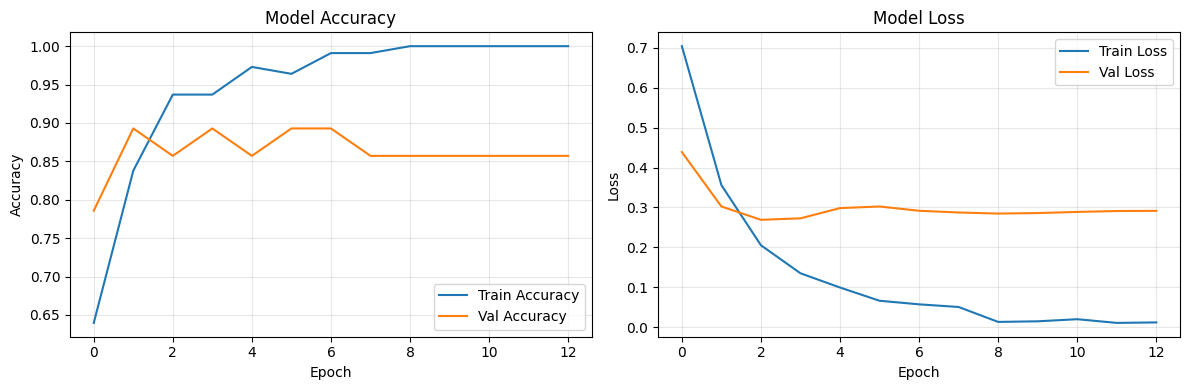

Model Deep Learning berhasil disimpan!


In [113]:
print("Training Model 3: Deep Learning (MLP)...")

# One-hot encode untuk multi-class
num_classes = len(le.classes_)
y_train_dl = to_categorical(y_train, num_classes=num_classes)
y_test_dl = to_categorical(y_test, num_classes=num_classes)

# Bangun model
model_dl = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile
model_dl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model_dl.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

# Training
start_time = time.time()
history = model_dl.fit(
    X_train_scaled, y_train_dl,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=0
)
dl_time = time.time() - start_time

# Evaluasi
loss, acc_dl = model_dl.evaluate(X_test_scaled, y_test_dl, verbose=0)
y_pred_dl = np.argmax(model_dl.predict(X_test_scaled), axis=1)

print(f"Selesai dalam {dl_time:.2f} detik")
print(f"Akurasi Deep Learning: {acc_dl*100:.2f}%")
print("\nClassification Report (Deep Learning):")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Simpan model
model_dl.save('model_mlp.h5')
print("Model Deep Learning berhasil disimpan!")

--- TABEL PERBANDINGAN MODEL ---
              Model  Accuracy  Training Time (sec)
      Random Forest  0.714286             0.303236
Deep Learning (MLP)  0.685714             3.332660
K-Nearest Neighbors  0.628571             0.012152


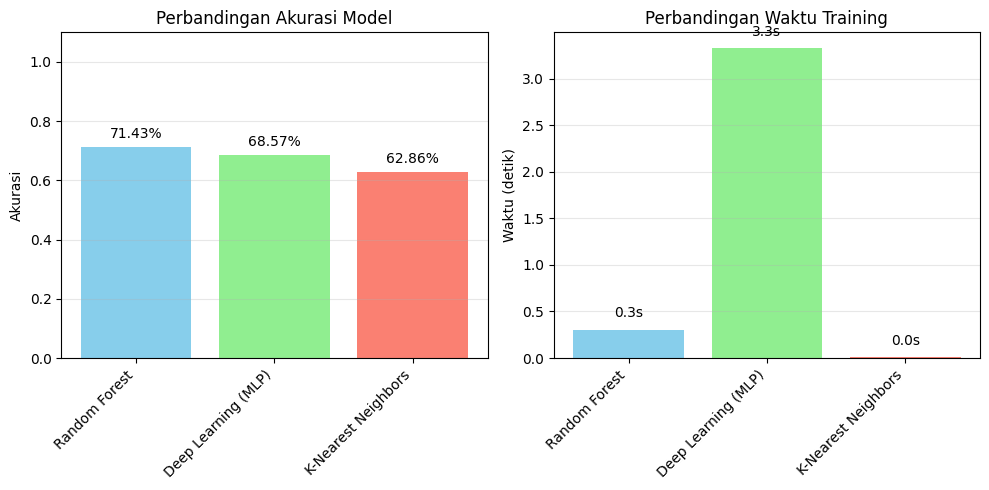

In [114]:
# Membuat DataFrame perbandingan
results = pd.DataFrame({
    'Model': ['K-Nearest Neighbors', 'Random Forest', 'Deep Learning (MLP)'],
    'Accuracy': [acc_knn, acc_rf, acc_dl],
    'Training Time (sec)': [knn_time, rf_time, dl_time]
})

# Urutkan dari akurasi tertinggi
results = results.sort_values(by='Accuracy', ascending=False)

print("--- TABEL PERBANDINGAN MODEL ---")
print(results.to_string(index=False))

# Visualisasi
plt.figure(figsize=(10, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
bars = plt.bar(results['Model'], results['Accuracy'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Tambah nilai di atas batang
for bar, acc in zip(bars, results['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{acc*100:.2f}%', ha='center', va='bottom')

# Plot waktu training
plt.subplot(1, 2, 2)
bars = plt.bar(results['Model'], results['Training Time (sec)'],
               color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Perbandingan Waktu Training')
plt.ylabel('Waktu (detik)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, time_val in zip(bars, results['Training Time (sec)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{time_val:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()


1. Ekstraksi Fitur per Trial
Ditemukan 11 trials: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

2. Analisis Performa per Trial dengan 3 Model

--- Analisis Trial 1 ---
  Jumlah fitur: 54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 60.00%
  RF Accuracy: 68.57%
  MLP Accuracy: 71.43%

--- Analisis Trial 2 ---
  Jumlah fitur: 54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 68.57%
  RF Accuracy: 74.29%
  MLP Accuracy: 60.00%

--- Analisis Trial 3 ---
  Jumlah fitur: 54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 68.57%
  RF Accuracy: 77.14%
  MLP Accuracy: 68.57%

--- Analisis Trial 4 ---
  Jumlah fitur: 54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 65.71%
  RF Accuracy: 71.43%
  MLP Accuracy: 65.71%

--- Analisis Trial 5 ---
  Jumlah fitur: 54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 71.43%
  RF Accuracy: 74.29%
  MLP Accuracy: 65.71%

--- Analisis Trial 6 ---
  Jumlah fitur: 36


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 62.86%
  RF Accuracy: 60.00%
  MLP Accuracy: 65.71%

--- Analisis Trial 7 ---
  Jumlah fitur: 36


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 57.14%
  RF Accuracy: 71.43%
  MLP Accuracy: 60.00%

--- Analisis Trial 8 ---
  Jumlah fitur: 36


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 68.57%
  RF Accuracy: 65.71%
  MLP Accuracy: 62.86%

--- Analisis Trial 9 ---
  Jumlah fitur: 36


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 68.57%
  RF Accuracy: 80.00%
  MLP Accuracy: 80.00%

--- Analisis Trial 10 ---
  Jumlah fitur: 18


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  KNN Accuracy: 65.71%
  RF Accuracy: 65.71%
  MLP Accuracy: 68.57%

3. Visualisasi Hasil per Trial


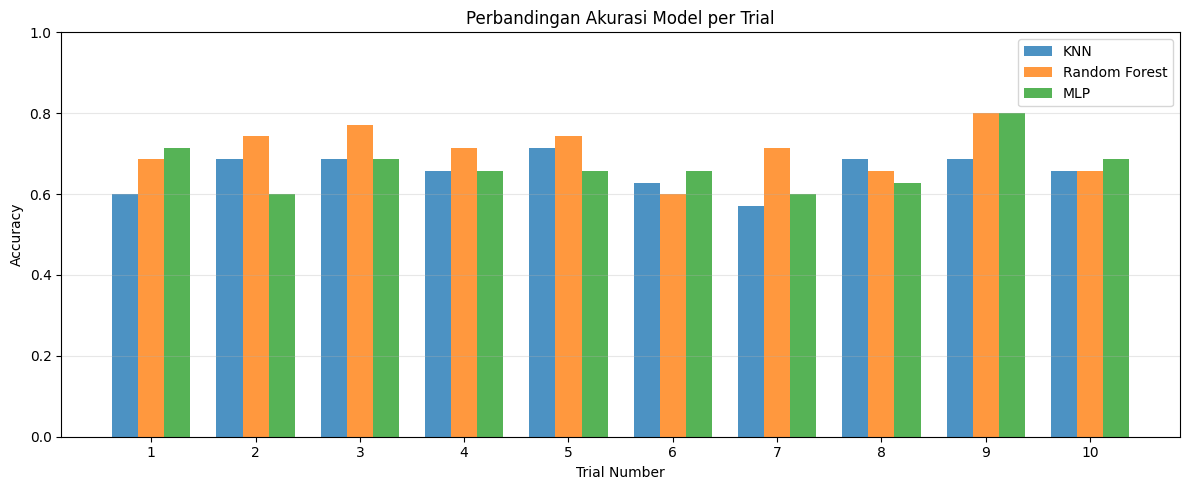

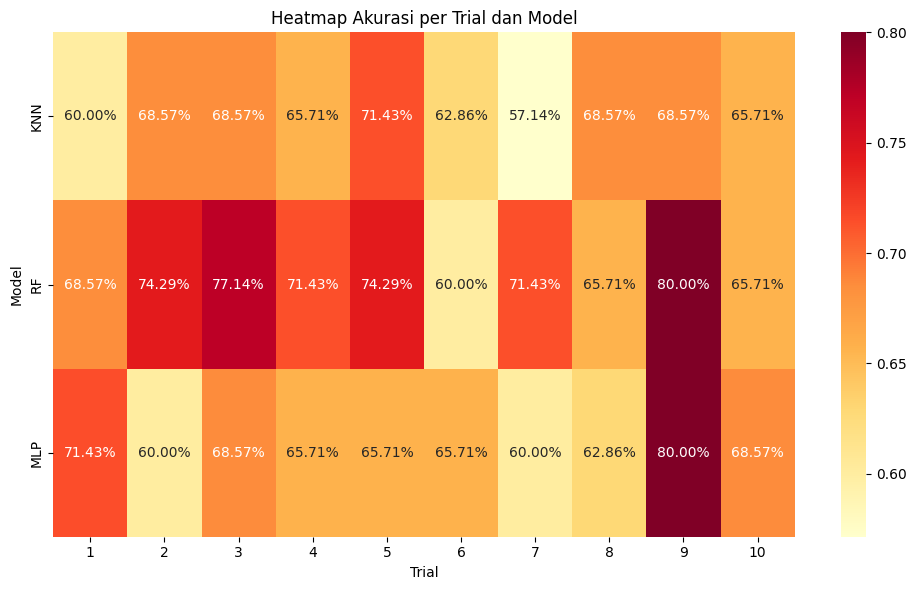

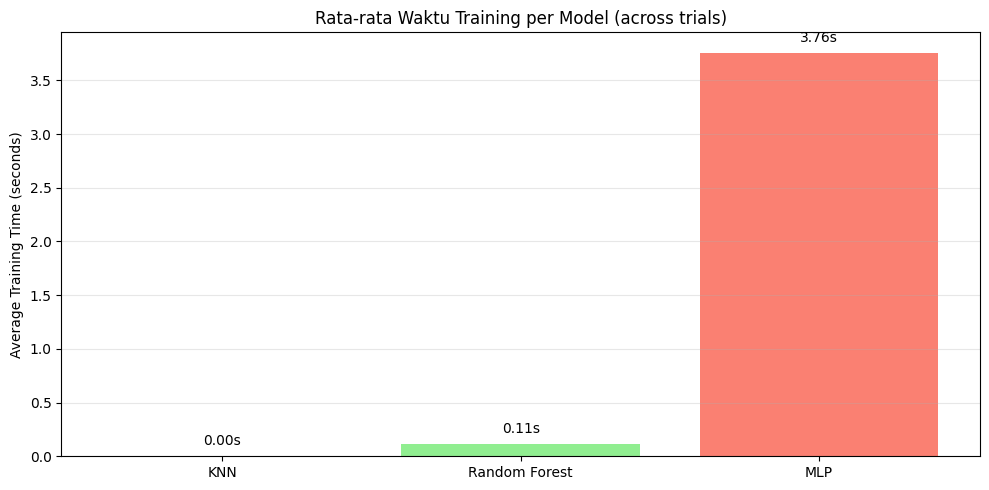


RINGKASAN ANALISIS PER TRIAL
 Trial    KNN Random Forest    MLP
     1 60.00%        68.57% 71.43%
     2 68.57%        74.29% 60.00%
     3 68.57%        77.14% 68.57%
     4 65.71%        71.43% 65.71%
     5 71.43%        74.29% 65.71%
     6 62.86%        60.00% 65.71%
     7 57.14%        71.43% 60.00%
     8 68.57%        65.71% 62.86%
     9 68.57%        80.00% 80.00%
    10 65.71%        65.71% 68.57%

TRIAL TERBAIK UNTUK SETIAP MODEL
KNN: Trial 5 (71.43%)
RF: Trial 9 (80.00%)
MLP: Trial 9 (80.00%)

ANALISIS AGGREGASI MULTIPLE TRIALS

Strategi: Menggabungkan fitur dari beberapa trial
3 Trial terbaik berdasarkan Random Forest: [9, 3, 5]

Total fitur setelah kombinasi: 144

--- Model dengan Fitur Gabungan (3 Trial Terbaik) ---
Random Forest dengan fitur gabungan: 80.00%
Random Forest dengan SEMUA fitur: 71.43%
✓ Fitur gabungan menghasilkan performa LEBIH BAIK

ANALISIS JENIS FITUR PER TRIAL

Jenis fitur yang ditemukan (18 jenis):
  1. air_time
  2. disp_index
  3. gmrt_in_air
 

In [115]:
# ==================== 14.1: EKSTRAKSI FITUR PER TRIAL ====================
print("\n1. Ekstraksi Fitur per Trial")

# Identifikasi semua trial yang ada dalam dataset
trial_numbers = set()
for col in X.columns:
    # Cari angka di akhir nama kolom (misal: air_time1, disp_index2, dst)
    for i in range(1, 26):  # Trial 1-25
        if col.endswith(str(i)):
            trial_numbers.add(i)
            break

trial_numbers = sorted(list(trial_numbers))
print(f"Ditemukan {len(trial_numbers)} trials: {trial_numbers}")

# ==================== 14.2: ANALISIS PER TRIAL DENGAN 3 MODEL ====================
print("\n2. Analisis Performa per Trial dengan 3 Model")

results_per_trial = []

for trial in trial_numbers[:10]:  # Analisis 10 trial pertama untuk efisiensi
    print(f"\n--- Analisis Trial {trial} ---")

    # Ekstrak fitur untuk trial ini
    trial_features = [col for col in X.columns if col.endswith(str(trial))]

    if len(trial_features) == 0:
        print(f"  Tidak ada fitur untuk trial {trial}")
        continue

    print(f"  Jumlah fitur: {len(trial_features)}")

    # Pisahkan data untuk trial ini
    X_trial = X[trial_features]

    # Split dataset
    X_train_trial, X_test_trial, y_train_trial, y_test_trial = train_test_split(
        X_trial, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scaling
    scaler_trial = StandardScaler()
    X_train_trial_scaled = scaler_trial.fit_transform(X_train_trial)
    X_test_trial_scaled = scaler_trial.transform(X_test_trial)

    trial_results = {'Trial': trial, 'Features': len(trial_features)}

    # Model 1: KNN
    start_time = time.time()
    knn_trial = KNeighborsClassifier(n_neighbors=5)
    knn_trial.fit(X_train_trial_scaled, y_train_trial)
    acc_knn_trial = knn_trial.score(X_test_trial_scaled, y_test_trial)
    trial_results['KNN_Acc'] = acc_knn_trial
    trial_results['KNN_Time'] = time.time() - start_time

    # Model 2: Random Forest
    start_time = time.time()
    rf_trial = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_trial.fit(X_train_trial_scaled, y_train_trial)
    acc_rf_trial = rf_trial.score(X_test_trial_scaled, y_test_trial)
    trial_results['RF_Acc'] = acc_rf_trial
    trial_results['RF_Time'] = time.time() - start_time

    # Model 3: MLP (sederhana)
    start_time = time.time()

    # One-hot encode
    y_train_trial_dl = to_categorical(y_train_trial, num_classes=num_classes)
    y_test_trial_dl = to_categorical(y_test_trial, num_classes=num_classes)

    # Model kecil untuk efisiensi
    mlp_trial = Sequential([
        Dense(32, activation='relu', input_shape=(len(trial_features),)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    mlp_trial.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    mlp_trial.fit(X_train_trial_scaled, y_train_trial_dl,
                  epochs=30, batch_size=16, verbose=0)

    acc_mlp_trial = mlp_trial.evaluate(X_test_trial_scaled, y_test_trial_dl, verbose=0)[1]
    trial_results['MLP_Acc'] = acc_mlp_trial
    trial_results['MLP_Time'] = time.time() - start_time

    results_per_trial.append(trial_results)

    print(f"  KNN Accuracy: {acc_knn_trial*100:.2f}%")
    print(f"  RF Accuracy: {acc_rf_trial*100:.2f}%")
    print(f"  MLP Accuracy: {acc_mlp_trial*100:.2f}%")

# ==================== 14.3: VISUALISASI HASIL PER TRIAL ====================
print("\n3. Visualisasi Hasil per Trial")

if results_per_trial:
    results_df = pd.DataFrame(results_per_trial)

    # Plot 1: Perbandingan Akurasi per Trial
    plt.figure(figsize=(12, 5))

    x = range(len(results_df))
    width = 0.25

    plt.bar([i - width for i in x], results_df['KNN_Acc'], width, label='KNN', alpha=0.8)
    plt.bar(x, results_df['RF_Acc'], width, label='Random Forest', alpha=0.8)
    plt.bar([i + width for i in x], results_df['MLP_Acc'], width, label='MLP', alpha=0.8)

    plt.xlabel('Trial Number')
    plt.ylabel('Accuracy')
    plt.title('Perbandingan Akurasi Model per Trial')
    plt.xticks(x, results_df['Trial'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Plot 2: Heatmap Akurasi
    fig, ax = plt.subplots(figsize=(10, 6))

    accuracy_data = results_df[['KNN_Acc', 'RF_Acc', 'MLP_Acc']].T
    sns.heatmap(accuracy_data, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=results_df['Trial'], yticklabels=['KNN', 'RF', 'MLP'],
                ax=ax)

    plt.title('Heatmap Akurasi per Trial dan Model')
    plt.xlabel('Trial')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    # Plot 3: Waktu Training per Model
    plt.figure(figsize=(10, 5))

    time_data = results_df[['KNN_Time', 'RF_Time', 'MLP_Time']].mean()

    plt.bar(['KNN', 'Random Forest', 'MLP'], time_data,
            color=['skyblue', 'lightgreen', 'salmon'])

    plt.ylabel('Average Training Time (seconds)')
    plt.title('Rata-rata Waktu Training per Model (across trials)')
    plt.grid(axis='y', alpha=0.3)

    for i, val in enumerate(time_data):
        plt.text(i, val + 0.1, f'{val:.2f}s', ha='center')

    plt.tight_layout()
    plt.show()

    # Tabel ringkasan
    print("\n" + "="*60)
    print("RINGKASAN ANALISIS PER TRIAL")
    print("="*60)

    summary = results_df[['Trial', 'KNN_Acc', 'RF_Acc', 'MLP_Acc']].copy()
    summary.columns = ['Trial', 'KNN', 'Random Forest', 'MLP']

    # Format sebagai persentase
    for col in ['KNN', 'Random Forest', 'MLP']:
        summary[col] = summary[col].apply(lambda x: f'{x*100:.2f}%')

    print(summary.to_string(index=False))

    # Identifikasi trial terbaik
    print("\n" + "="*60)
    print("TRIAL TERBAIK UNTUK SETIAP MODEL")
    print("="*60)

    for model in ['KNN_Acc', 'RF_Acc', 'MLP_Acc']:
        best_idx = results_df[model].idxmax()
        best_trial = results_df.loc[best_idx, 'Trial']
        best_acc = results_df.loc[best_idx, model]
        print(f"{model.split('_')[0]}: Trial {best_trial} ({best_acc*100:.2f}%)")

# ==================== 14.4: ANALISIS AGGREGASI TRIAL ====================
print("\n" + "="*60)
print("ANALISIS AGGREGASI MULTIPLE TRIALS")
print("="*60)

# Strategi: Gabungkan fitur dari beberapa trial terbaik
print("\nStrategi: Menggabungkan fitur dari beberapa trial")

# Identifikasi trial terbaik berdasarkan RF (bisa diganti dengan voting)
best_trials = results_df.sort_values('RF_Acc', ascending=False)['Trial'].head(3).tolist()
print(f"3 Trial terbaik berdasarkan Random Forest: {best_trials}")

# Gabungkan fitur dari trial terbaik
combined_features = []
for trial in best_trials:
    trial_features = [col for col in X.columns if col.endswith(str(trial))]
    combined_features.extend(trial_features)

print(f"\nTotal fitur setelah kombinasi: {len(combined_features)}")

# Bangun model dengan fitur gabungan
X_combined = X[combined_features]

# Split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler_comb = StandardScaler()
X_train_comb_scaled = scaler_comb.fit_transform(X_train_comb)
X_test_comb_scaled = scaler_comb.transform(X_test_comb)

# Model dengan fitur gabungan
print("\n--- Model dengan Fitur Gabungan (3 Trial Terbaik) ---")

# Random Forest
rf_comb = RandomForestClassifier(n_estimators=100, random_state=42)
rf_comb.fit(X_train_comb_scaled, y_train_comb)
acc_rf_comb = rf_comb.score(X_test_comb_scaled, y_test_comb)

print(f"Random Forest dengan fitur gabungan: {acc_rf_comb*100:.2f}%")

# Bandingkan dengan model menggunakan semua fitur
print(f"Random Forest dengan SEMUA fitur: {acc_rf*100:.2f}%")

if acc_rf_comb > acc_rf:
    print("✓ Fitur gabungan menghasilkan performa LEBIH BAIK")
else:
    print("✗ Fitur gabungan menghasilkan performa LEBIH BURUK atau SAMA")

# ==================== 14.5: ANALISIS JENIS FITUR PER TRIAL ====================
print("\n" + "="*60)
print("ANALISIS JENIS FITUR PER TRIAL")
print("="*60)

# Analisis tipe fitur yang ada
feature_types = set()
for col in X.columns:
    # Ekstrak tipe fitur (sebelum angka trial)
    if any(col.endswith(str(i)) for i in range(1, 26)):
        # Hapus angka di akhir
        base_feature = ''.join([c for c in col if not c.isdigit()])
        feature_types.add(base_feature)

print(f"\nJenis fitur yang ditemukan ({len(feature_types)} jenis):")
for i, feat_type in enumerate(sorted(list(feature_types))[:20]):  # Tampilkan 20 pertama
    print(f"  {i+1}. {feat_type}")

# Analisis feature importance per jenis
if len(feature_types) > 0:
    print("\nAnalisis Feature Importance per Jenis Fitur:")

    feature_type_importance = {}
    for feat_type in list(feature_types)[:10]:  # Analisis 10 jenis pertama
        # Cari semua fitur dengan jenis ini
        type_features = [col for col in X.columns if feat_type in col]

        if len(type_features) > 0:
            # Hitung average importance dari model RF sebelumnya
            type_importance = 0
            count = 0

            for feat in type_features:
                if feat in feature_importance['feature'].values:
                    imp = feature_importance.loc[feature_importance['feature'] == feat, 'importance'].values[0]
                    type_importance += imp
                    count += 1

            if count > 0:
                feature_type_importance[feat_type] = type_importance / count

    # Urutkan dan tampilkan
    sorted_types = sorted(feature_type_importance.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 Jenis Fitur Berdasarkan Importance:")
    for i, (feat_type, imp) in enumerate(sorted_types[:10]):
        print(f"  {i+1}. {feat_type}: {imp:.4f}")

# ==================== 14.6: REKOMENDASI UNTUK DATASET ANDA ====================

print("\n" + "="*60)
print("ANALISIS SELESAI!")
print("="*60)